Alexander W. Criswell 10/15/25

Trying a test run with a broader frequency band but less resolution for computation's sake.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.collections import LineCollection
import matplotlib.cm
from matplotlib import patches
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate, MTDistGenMove, Move
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
np.random.seed(42)

In [5]:
def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = plt.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

In [6]:
default_cycler=cycler(color=['mediumorchid','teal','navy','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)

In [7]:
xp.cuda.is_available()

True

In [8]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [9]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [10]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq, lisa_noise_psd
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


In [11]:
test_rng = xp.random.default_rng(170817)

In [12]:
test_prior = GalacticBinaryPrior(test_rng)

In [13]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [14]:
samps = test_prior.sample_conditional(int(1e7))

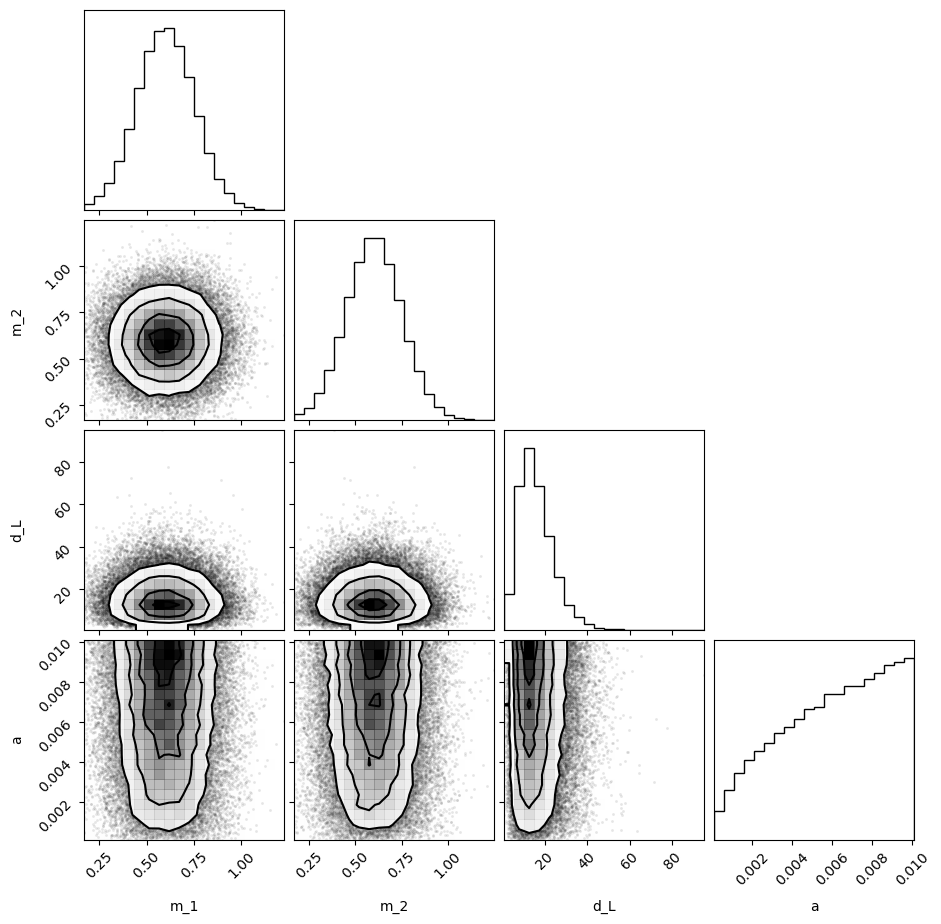

In [15]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [16]:
amps, fgws = get_amp_freq(samps)

In [17]:
test_hprior = PopulationHyperPrior(test_rng)

In [44]:
test_bin_width = 1e-6
test_fbins = xp.arange(1e-4,1e-1,test_bin_width)
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0,fbins=test_fbins)

In [45]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [ ]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [ ]:
data_N_res

In [ ]:
err = 1e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('Initial simulation with ad-hoc uncertainty')
# plt.ylim(1e-40,1e-36)
plt.show()

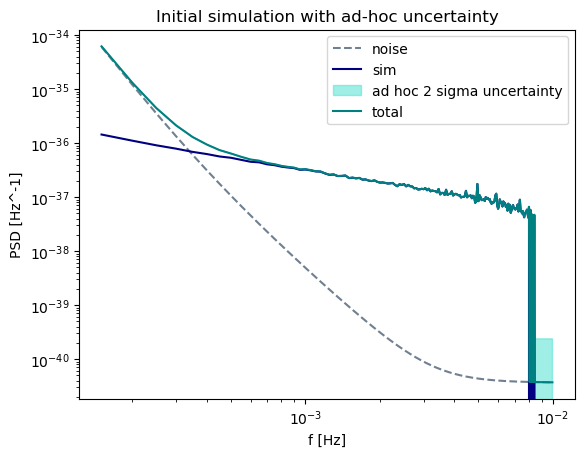

In [33]:
err = 1e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('Initial simulation with ad-hoc uncertainty')
# plt.ylim(1e-40,1e-36)
plt.show()

In [23]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':err,
            'Nres':data_N_res,
            'noise':lisa_noise_psd(test_f)}

In [24]:
test_rng = xp.random.default_rng(42)

In [25]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

Good. Carry on!

In [26]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x7c13605754f0>,
 'm_sigma': <distributions.invgamma at 0x7c13604edc70>,
 'd_gamma_a': <distributions.uniform at 0x7c13605a8f80>,
 'd_gamma_b': <distributions.uniform at 0x7c1360643aa0>,
 'a_alpha': <distributions.uniform at 0x7c136bf24920>}

In [27]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [28]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict,fbins=test_fbins)

In [29]:
eryn_popmodel.construct_likelihood(datadict)

In [30]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [31]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [32]:
## MH with prior draws as the proposal function
PriorMove = DistributionGenerate({'model_0':eryn_prior})

Build a custom Eryn move for the Poisson sampling...

In [33]:
class PoissonMove(Move):
    '''
    A static Poisson move. This will remain at the current state in the population parameter space, but force reevaluation of the likelihood,
    thereby allowing the sampler to marginalize over the intrinsic Poisson scatter in the likelihood.
    '''

    def __init__(self, **kwargs):

        Move.__init__(self, **kwargs)


    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):
        '''
        This is essentially a wrapper; the method will return the current state as the new proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim] representing
                coordinates for walkers.
            random (object): Current random state object.
            branches_inds (dict, optional): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max] representing which
                leaves are currently being used. (default: ``None``)
            **kwargs (ignored): This is added for compatibility. It is ignored in this function.

        Returns:
            tuple: (Proposed coordinates, factors) -> (dict, np.ndarray)
        
        '''
        factors = np.zeros((ntemps, nwalkers))
        return branches_coords, factors

    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):
        """
        
        This is essentially a wrapper; the method will return the current state as the new proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim] representing
                coordinates for walkers.
            random (object): Current random state object.
            branches_inds (dict, optional): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max] representing which
                leaves are currently being used. (default: ``None``)
            **kwargs (ignored): This is added for compatibility. It is ignored in this function.

        Returns:
            tuple: Tuple containing proposal information.
                First entry is the new coordinates as a dictionary with keys
                as ``branch_names`` and values as
                ``double `` np.ndarray[ntemps, nwalkers, nleaves_max, ndim] containing
                proposed coordinates. Second entry
                is the factors associated with the
                proposal necessary for detailed balance. This is effectively
                any term in the detailed balance fraction. +log of factors if
                in the numerator. -log of factors if in the denominator.

        """

        # set up all initial holders
        q = {}
        factors = {}
        new_inds = {}
        if branches_inds is None:
            branches_inds = {
                name: np.ones(coords.shape[:-1], dtype=bool)
                for name, coords in branches_coords
            }

        # iterate through branches and propose new points where inds == True
        for i, (name, coords, inds) in enumerate(
            zip(
                branches_coords.keys(),
                branches_coords.values(),
                branches_inds.values(),
            )
        ):
            # copy over previous info
            ntemps, nwalkers, _, _ = coords.shape
            q[name] = coords.copy()
            new_inds[name] = inds.copy()

            if i == 0:
                factors = np.zeros((ntemps, nwalkers))

            # add coordinates for new leaves
            inds_here = np.where(inds == True)
            num_inds_change = len(inds_here[0])

            old_points = coords[inds_here]

            q[name][inds_here] = old_points

        return q, factors

    def setup(self, branches_coords):
        """Any setup for the proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim]. These are the curent
                coordinates for all the walkers.

        """
    
    def propose(self, model, state):
        """Use the move to generate a proposal and compute the acceptance

        Args:
            model (:class:`eryn.model.Model`): Carrier of sampler information.
            state (:class:`State`): Current state of the sampler.

        Returns:
            :class:`State`: State of sampler after proposal is complete.

        """

        self.setup(state.branches_coords)

        # get all branch names for gibbs setup
        all_branch_names = list(state.branches.keys())

        # get initial shape information
        ntemps, nwalkers, _, _ = state.branches[all_branch_names[0]].shape

        # in case there are no leaves yet
        accepted = np.zeros((ntemps, nwalkers), dtype=bool)

        # iterate through gibbs setup
        for branch_names_run, inds_run in self.gibbs_sampling_setup_iterator(
            all_branch_names
        ):
            # setup supplemental information
            if not np.all(
                np.asarray(list(state.branches_supplemental.values())) == None
            ):
                new_branch_supps = deepcopy(state.branches_supplemental)
            else:
                new_branch_supps = None

            if state.supplemental is not None:
                new_supps = deepcopy(state.supplemental)
            else:
                new_supps = None

            # setup information according to gibbs info
            (
                coords_going_for_proposal,
                inds_going_for_proposal,
                at_least_one_proposal,
            ) = self.setup_proposals(
                branch_names_run, inds_run, state.branches_coords, state.branches_inds
            )

            # if no walkers are actually being proposed
            if not at_least_one_proposal:
                continue

            self.current_model = model
            self.current_state = state

            # Get the move-specific proposal.
            q, factors = self.get_proposal(
                coords_going_for_proposal,
                model.random,
                branches_inds=inds_going_for_proposal,
                supps=new_supps,
                branch_supps=new_branch_supps,
            )

            # account for gibbs sampling
            self.cleanup_proposals_gibbs(
                branch_names_run, inds_run, q, state.branches_coords
            )

            # order everything properly
            q, _, new_branch_supps = self.ensure_ordering(
                list(state.branches.keys()), q, state.branches_inds, new_branch_supps
            )

            # if not wrapping with mutliple try (normal route)
            if not hasattr(self, "mt_ll") or not hasattr(self, "mt_lp"):
                # Compute prior of the proposed position
                logp = model.compute_log_prior_fn(q, inds=state.branches_inds)

                self.fix_logp_gibbs(
                    branch_names_run, inds_run, logp, state.branches_inds
                )

                # Compute the lnprobs of the proposed position.
                # Can adjust supplementals in place
                logl, new_blobs = model.compute_log_like_fn(
                    q,
                    inds=state.branches_inds,
                    logp=logp,
                    supps=new_supps,
                    branch_supps=new_branch_supps,
                )

            else:
                # if already computed in multiple try
                logl = self.mt_ll
                logp = self.mt_lp
                new_blobs = None

            # get log posterior
            logP = self.compute_log_posterior(logl, logp)

            # # get previous information
            # prev_logl = state.log_like

            # prev_logp = state.log_prior

            # # takes care of tempering
            # prev_logP = self.compute_log_posterior(prev_logl, prev_logp)

            # # difference
            # lnpdiff = factors + logP - prev_logP

            # 100% acceptance
            accepted = np.ones((ntemps, nwalkers),dtype=bool)

            # Update the parameters
            new_state = State(
                q,
                log_like=logl,
                log_prior=logp,
                blobs=new_blobs,
                inds=state.branches_inds,
                supplemental=new_supps,
                branch_supplemental=new_branch_supps,
            )

            state = self.update(state, new_state, accepted)

            # add to move-specific accepted information
            self.accepted += accepted
            self.num_proposals += 1

        # temperature swaps
        if self.temperature_control is not None:
            state = self.temperature_control.temper_comps(state)
        return state, accepted

In [34]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]

Log-likelihood:
 [-1.18717148e+04 -1.13294848e+05 -1.31652364e+07 -6.78660685e+05
 -9.28347332e+06 -2.20931119e+04 -5.73134761e+04 -9.42548972e+04
 -1.57300719e+05 -1.17976066e+05]

Log-prior:
 [0.86118009 1.25089694 1.22826266 1.51522869 0.56837611 1.44484385
 1.33217912 1.55505861 1.53629572 1.57200972]


Build an Eryn ensemble with the full move mixture:

In [35]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           moves=[(StretchMove(),0.45),(PriorMove,0.1),(PoissonMove(),0.45)],
                           track_moves=True,
                          )

Let's look at the starting position...

In [36]:
## check intrinsic scatter in the likelihood?
starting_likes = []
starting_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(coords[i,:],return_spec=True)
    starting_likes.append(like_i)
    starting_astro.append(astro_i)

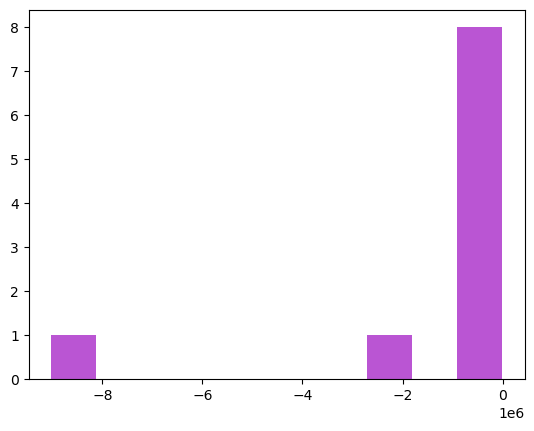

In [37]:
plt.figure()
plt.hist(starting_likes)
plt.show()

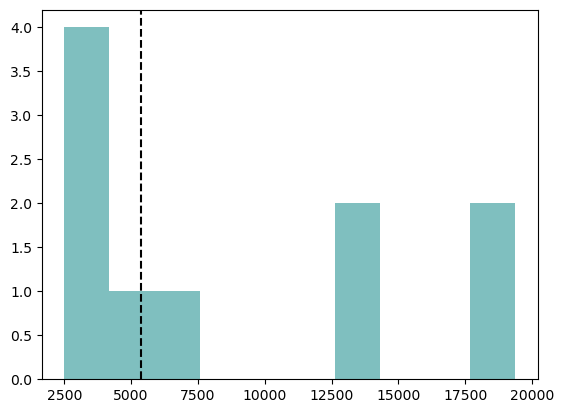

In [38]:
plt.figure()
plt.hist([starting_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

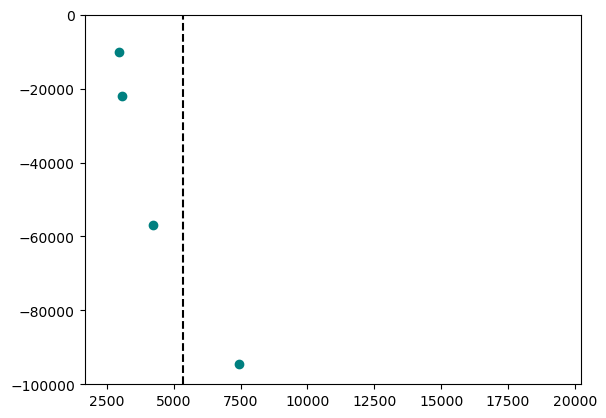

In [39]:
plt.figure()
plt.scatter([starting_astro[i][2] for i in range(nwalkers)],starting_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.ylim(-1e5,0)
plt.show()

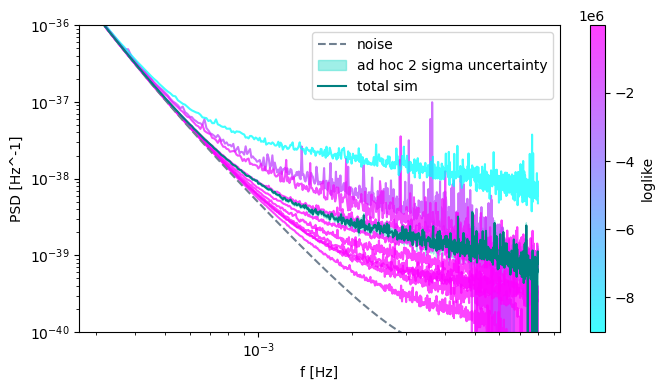

In [40]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=starting_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
# plt.xlim(5e-4,5e-3)
plt.tight_layout()
plt.show()

In [41]:
nsteps = 2000
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

  0%|                                                                                                                                                     | 0/2000 [00:00<?, ?it/s]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/moves/move.py:421: RuntimeWarning: invalid value encountered in divide
  return self.accepted / self.num_proposals
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [5:28:10<00:00,  9.85s/it]


In [42]:
ensemble.acceptance_fraction

array([[0.5635, 0.5745, 0.5715, 0.5795, 0.5695, 0.5575, 0.579 , 0.578 ,
        0.579 , 0.561 ]])

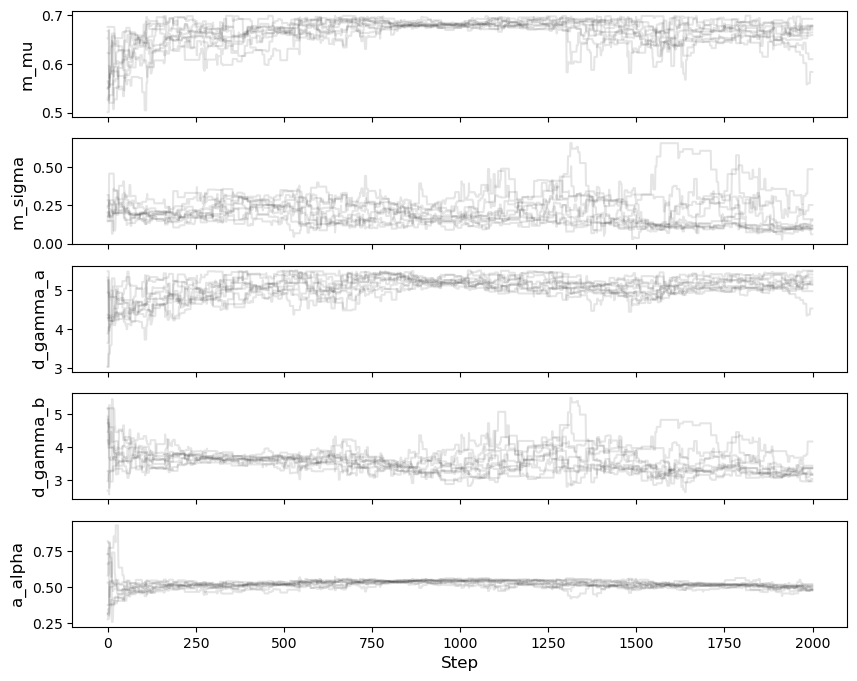

In [43]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

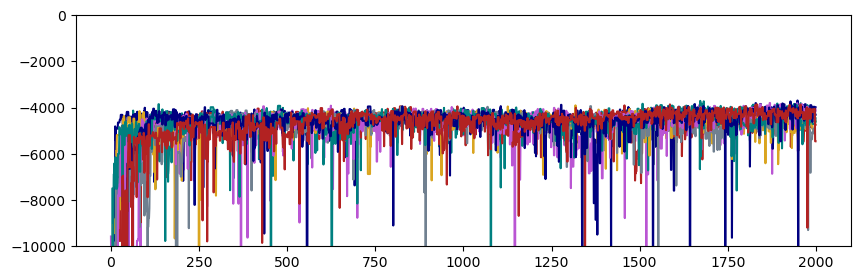

In [44]:
loglike = ensemble.get_log_posterior().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-1e4,0)
plt.show()

Where are they now?

In [45]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [46]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

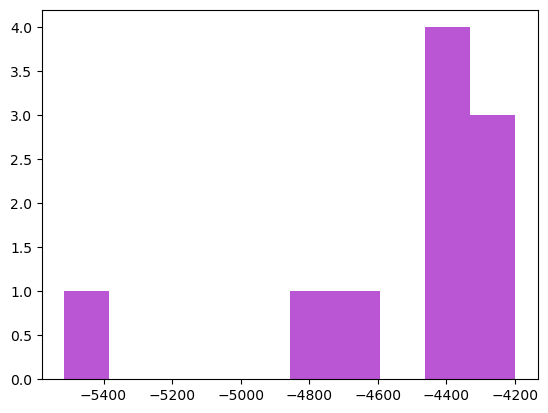

In [47]:
plt.figure()
plt.hist(current_likes)
plt.show()

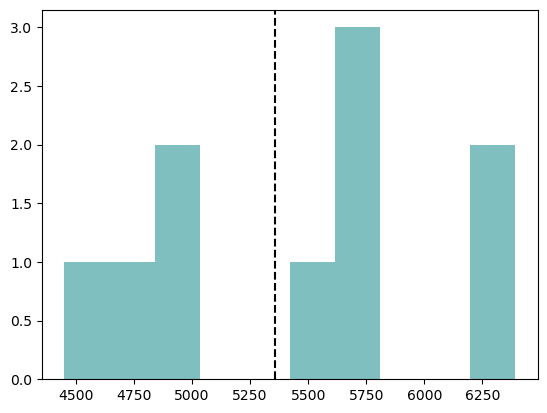

In [48]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

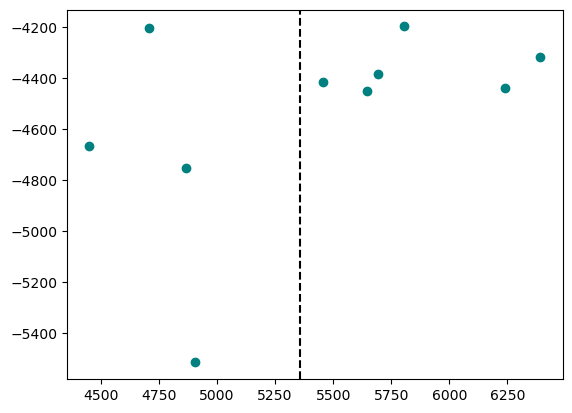

In [49]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

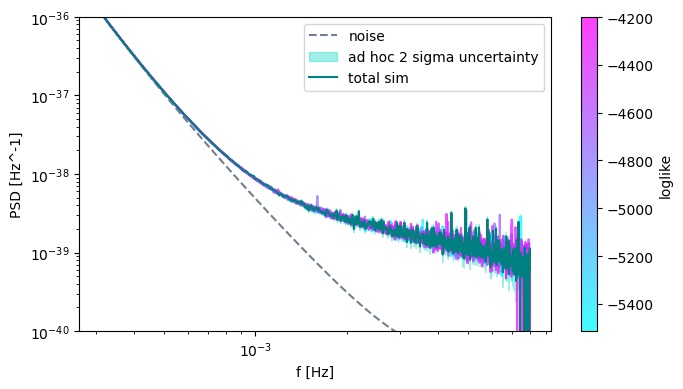

In [50]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
# plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [51]:
np.any(np.isnan(out.log_prior))

False

In [52]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [53]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

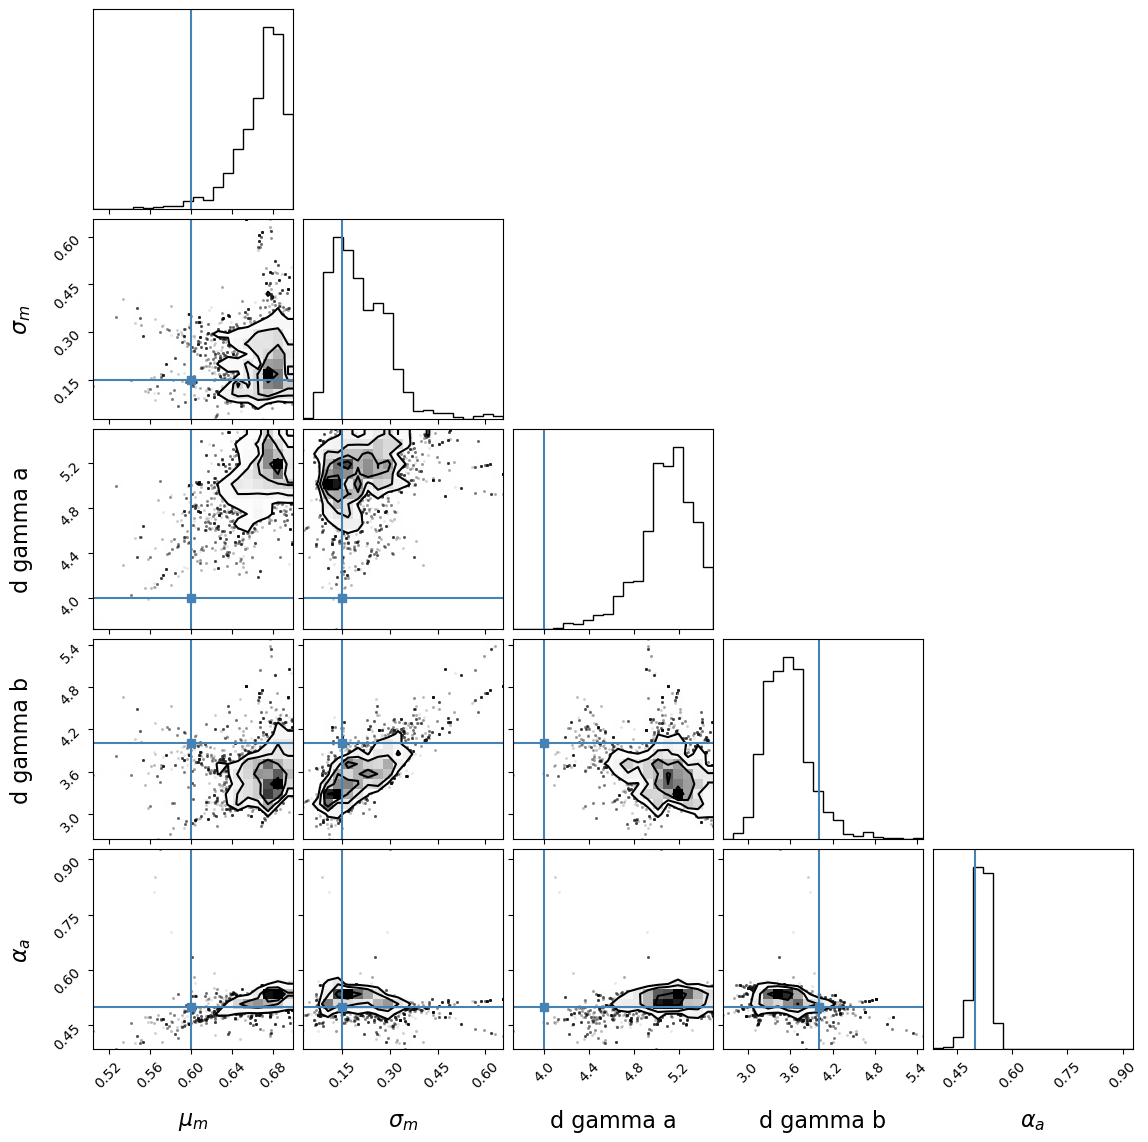

In [54]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[200:,:]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [57]:
ensemble.acceptance_fraction

array([[0.5635, 0.5745, 0.5715, 0.5795, 0.5695, 0.5575, 0.579 , 0.578 ,
        0.579 , 0.561 ]])

In [58]:
xp.array([1,2])

CUDARuntimeError: cudaErrorLaunchFailure: unspecified launch failure

In [58]:
nsteps = 250
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [17:48<00:00,  4.27s/it]


In [59]:
ensemble.acceptance_fraction

array([[0.562, 0.562, 0.556, 0.562, 0.588, 0.562, 0.586, 0.574, 0.558,
        0.58 ]])

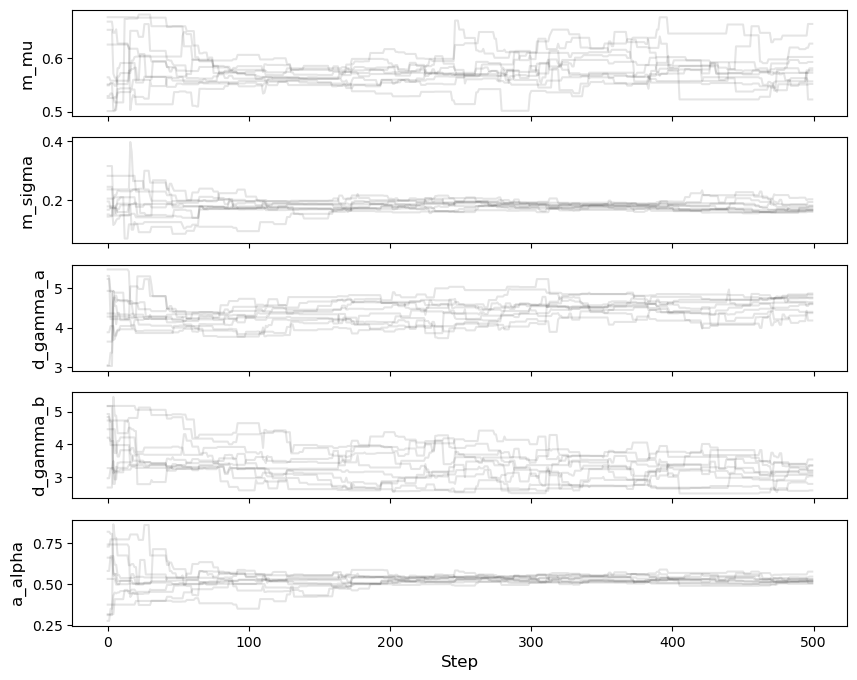

In [60]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

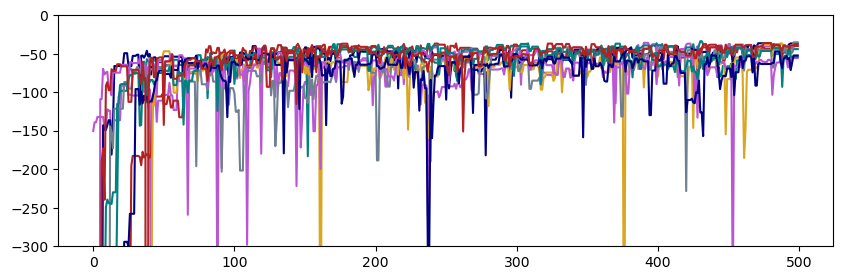

In [61]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

Where are they now?

In [62]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [63]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

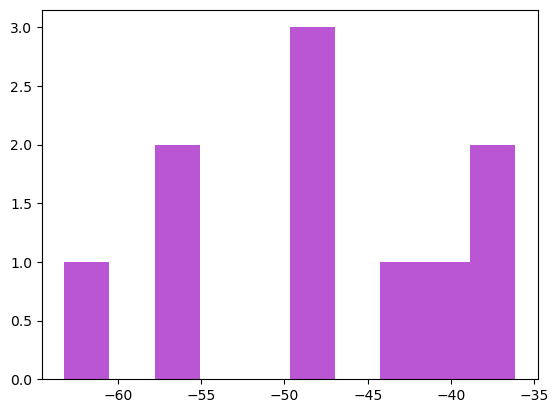

In [64]:
plt.figure()
plt.hist(current_likes)
plt.show()

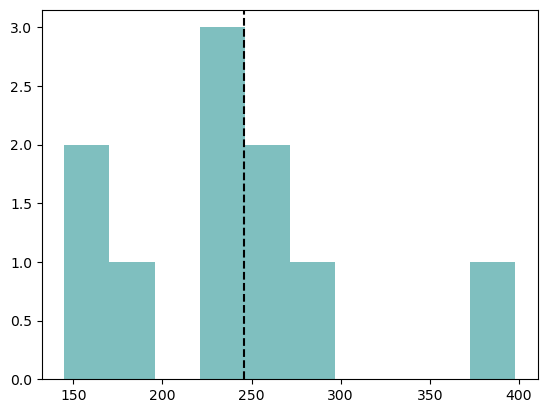

In [65]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

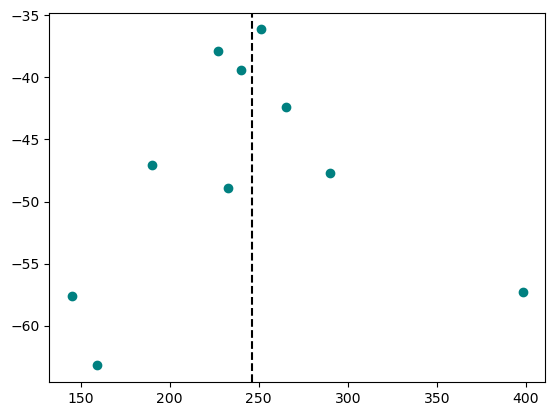

In [66]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

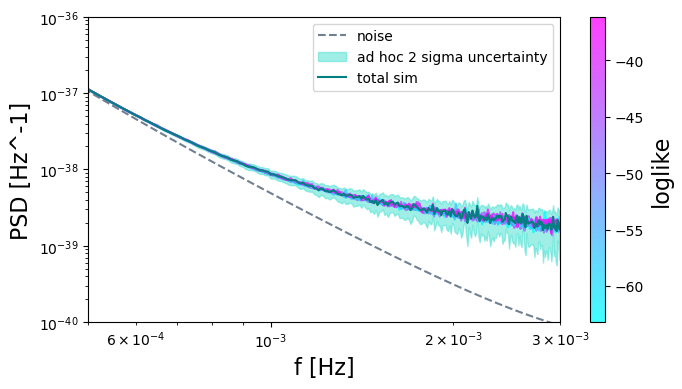

In [67]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [68]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [69]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

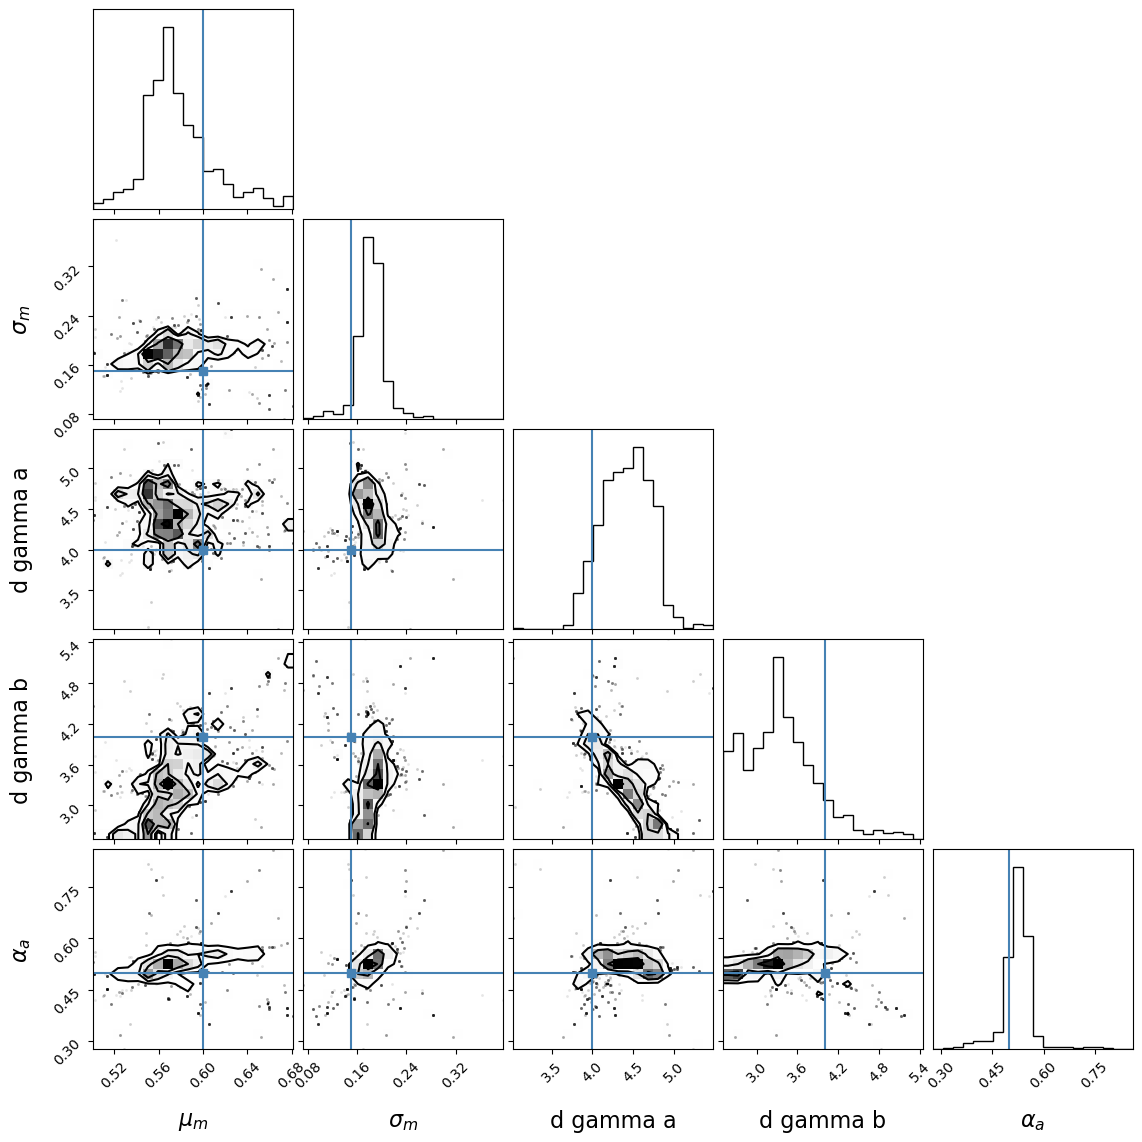

In [71]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [72]:
nsteps = 500
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [35:11<00:00,  4.22s/it]


In [73]:
ensemble.acceptance_fraction

array([[0.574, 0.586, 0.565, 0.576, 0.593, 0.575, 0.593, 0.6  , 0.564,
        0.597]])

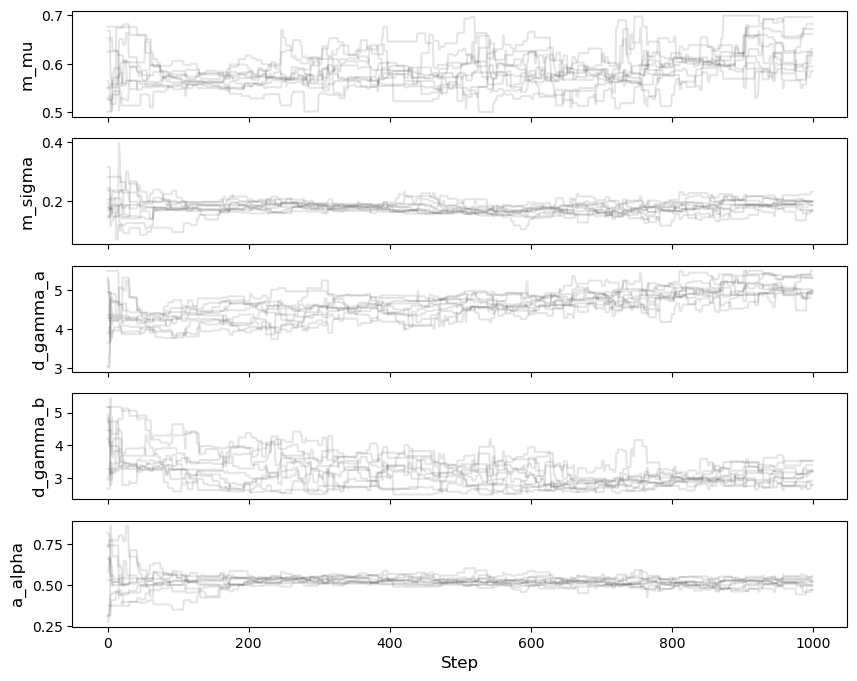

In [74]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

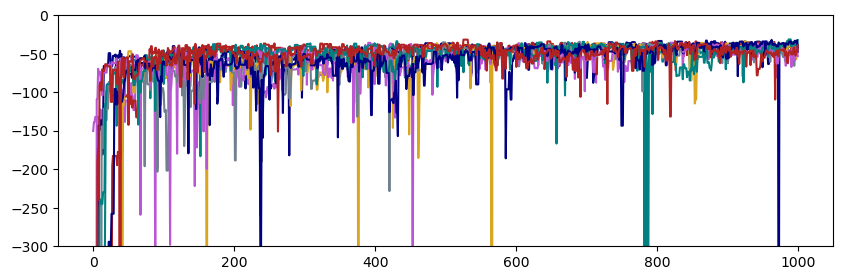

In [75]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

Where are they now?

In [76]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [77]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

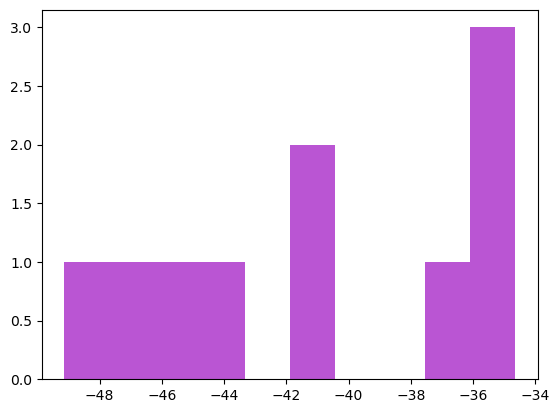

In [78]:
plt.figure()
plt.hist(current_likes)
plt.show()

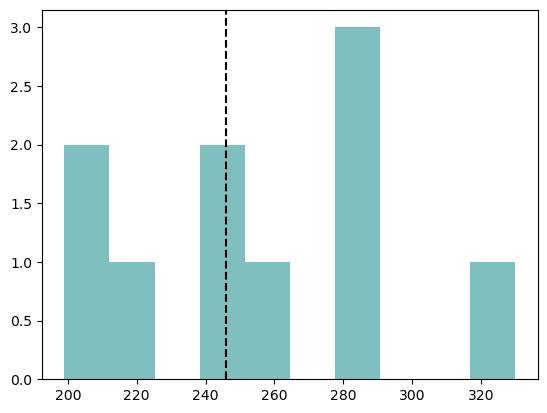

In [79]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

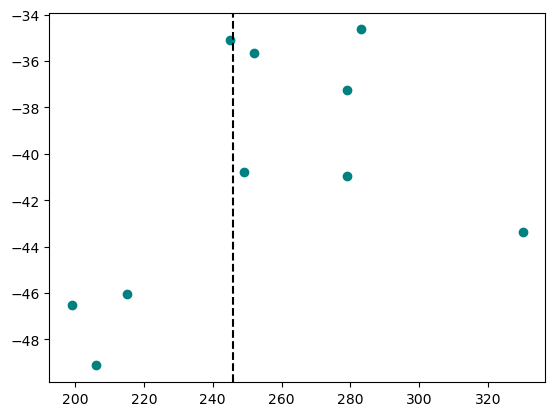

In [80]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

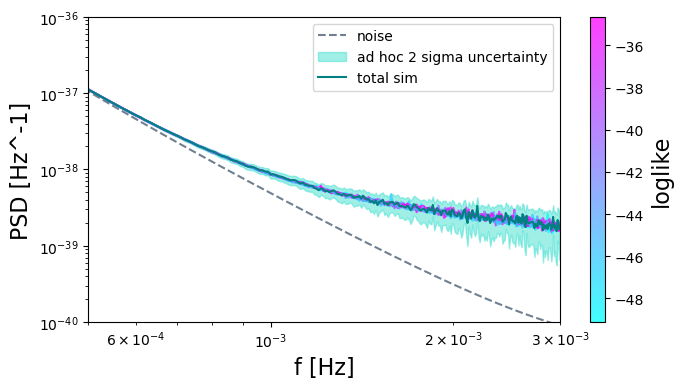

In [81]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [82]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [83]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

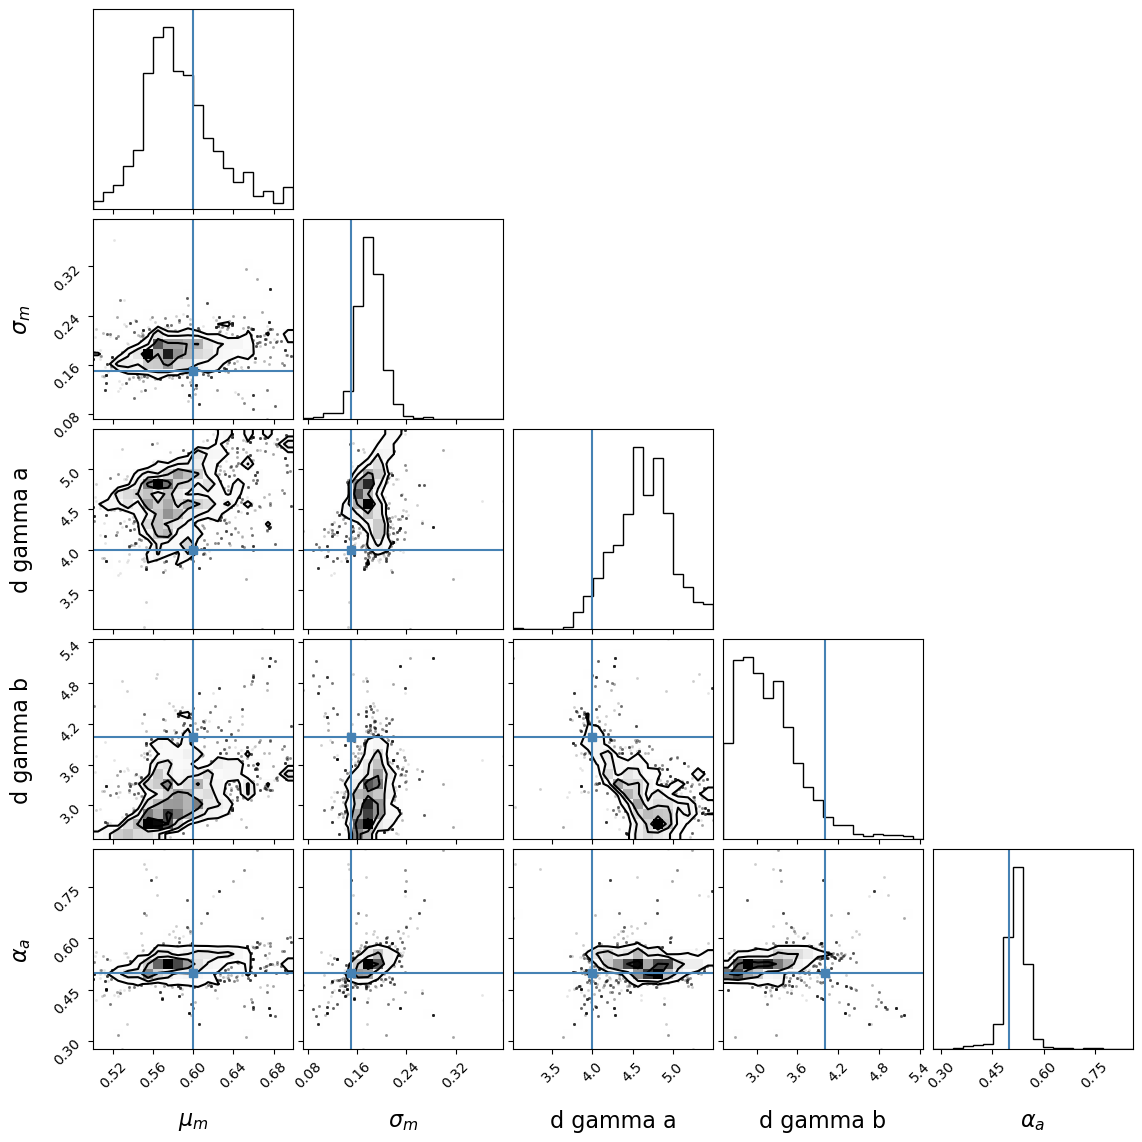

In [84]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [85]:
nsteps = 1000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:08:36<00:00,  4.12s/it]


In [86]:
ensemble.acceptance_fraction

array([[0.596 , 0.594 , 0.5875, 0.5935, 0.606 , 0.5885, 0.6035, 0.598 ,
        0.5825, 0.6055]])

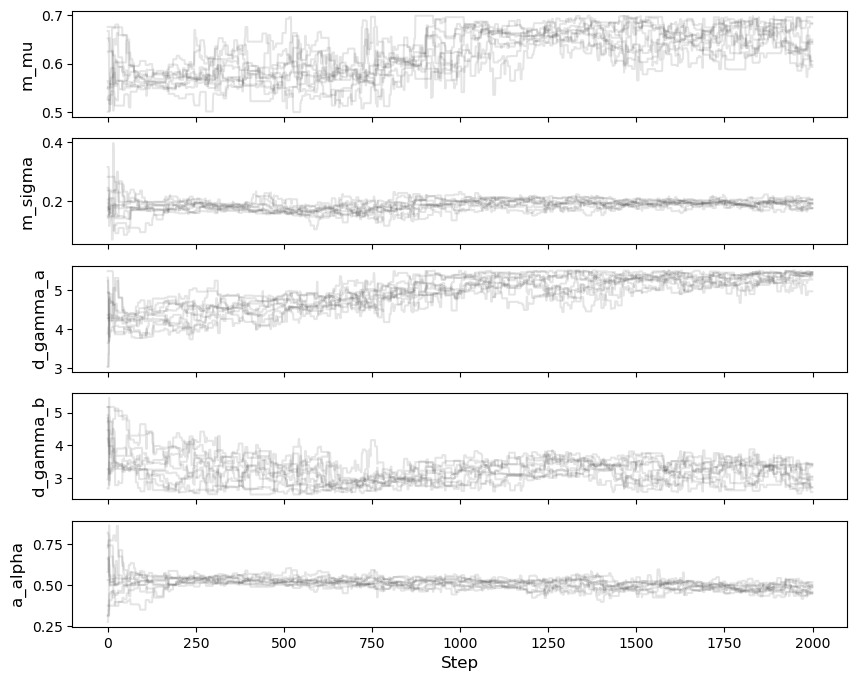

In [87]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

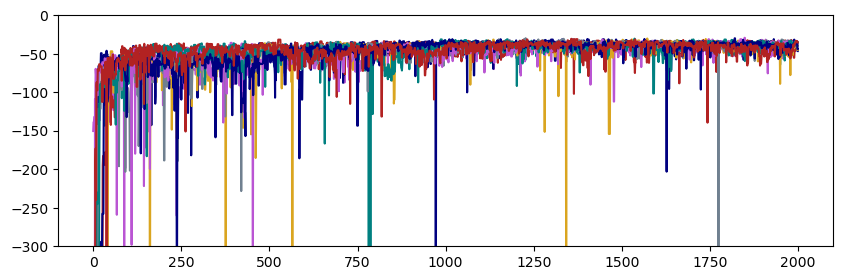

In [88]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

Where are they now?

In [89]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [90]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

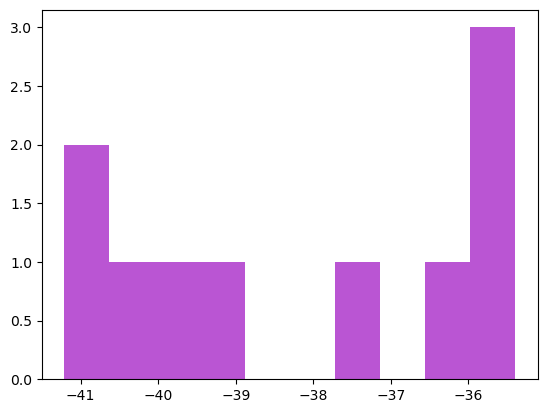

In [91]:
plt.figure()
plt.hist(current_likes)
plt.show()

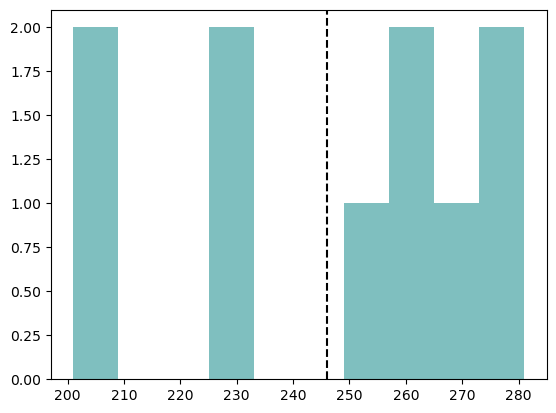

In [92]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

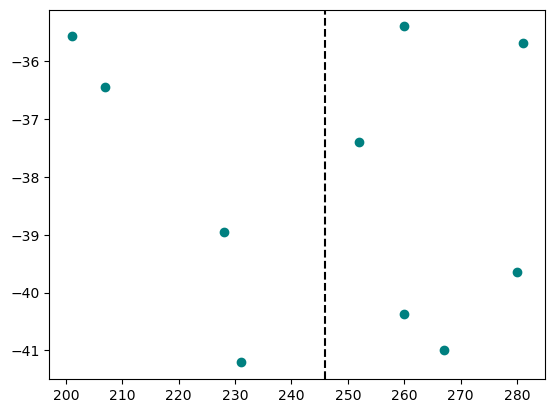

In [93]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

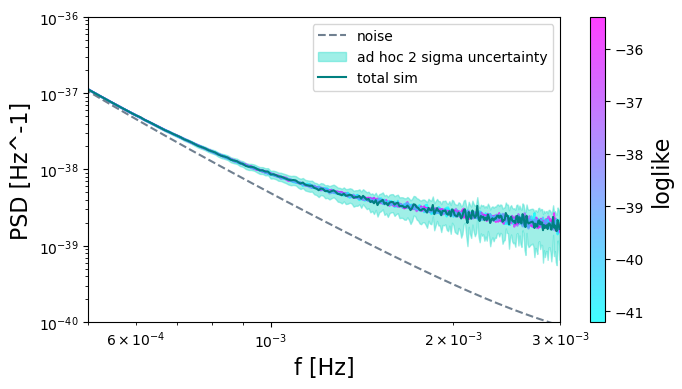

In [94]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [95]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [96]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

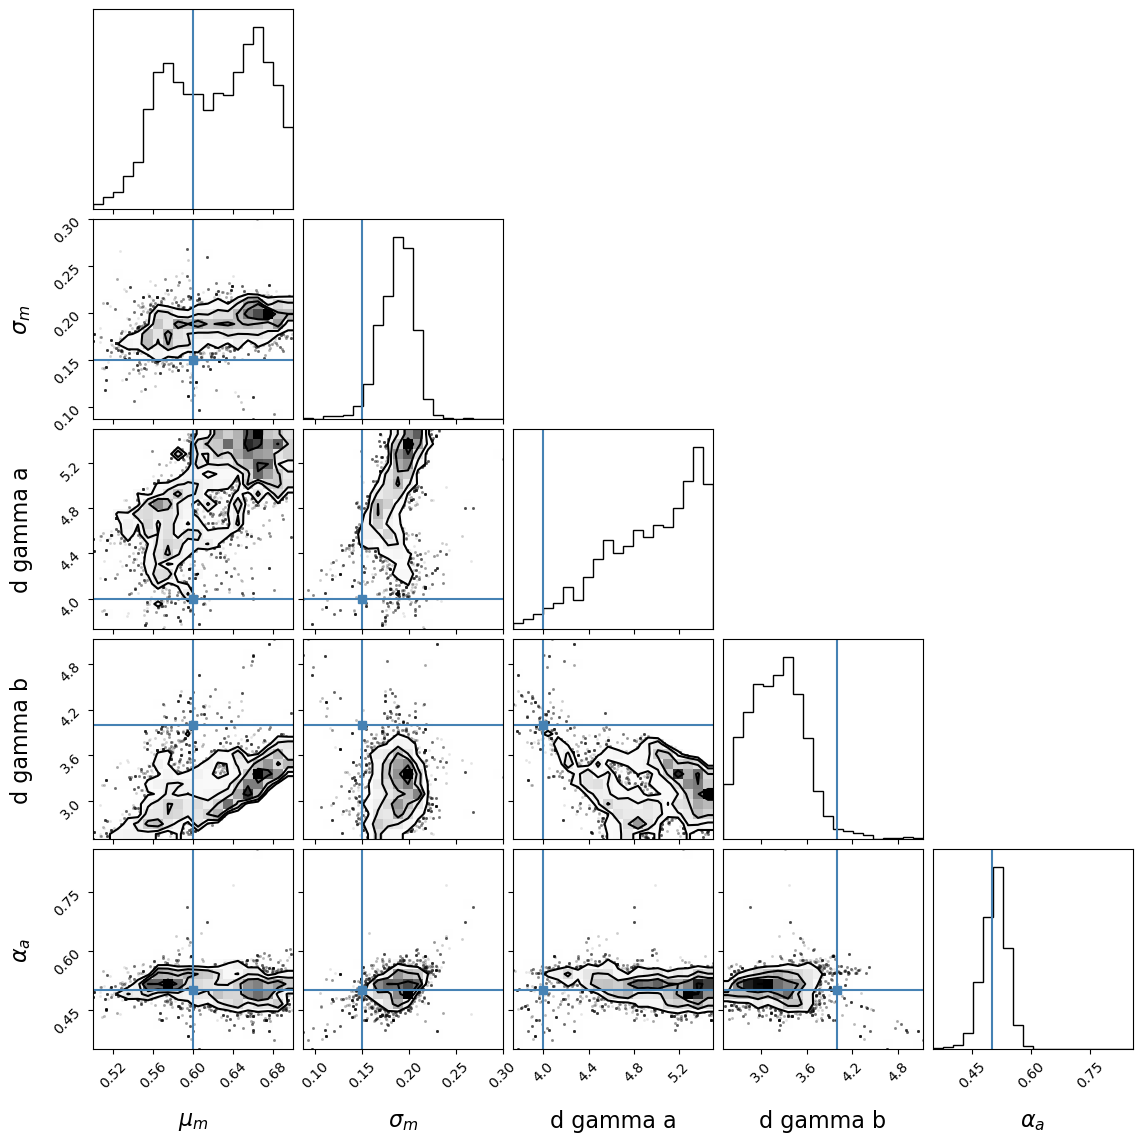

In [98]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[250:,]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [100]:
nsteps = 1000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:08:35<00:00,  4.12s/it]


In [101]:
ensemble.acceptance_fraction

array([[0.59933333, 0.59933333, 0.58533333, 0.59633333, 0.606     ,
        0.60133333, 0.60033333, 0.60133333, 0.592     , 0.611     ]])

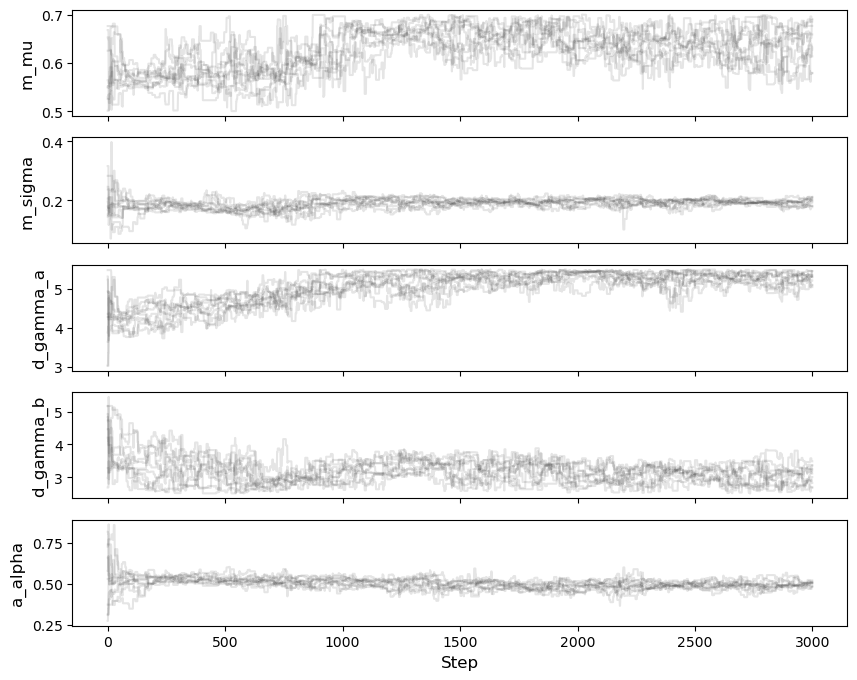

In [115]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
plt.savefig('lowf_nbv14_chains.png',dpi=200)
plt.show()

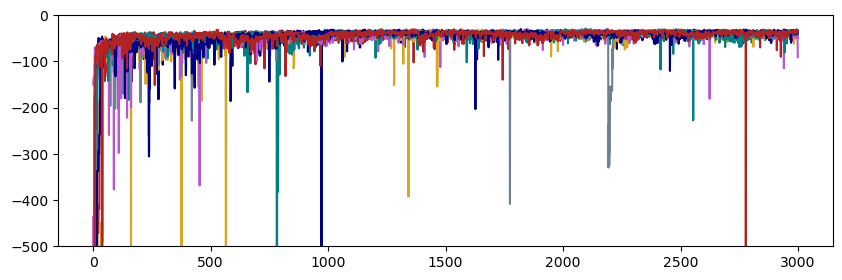

In [118]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-500,0)
plt.savefig('lowf_nbv14_loglikes.png',dpi=200)
plt.show()

Where are they now?

In [104]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [105]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

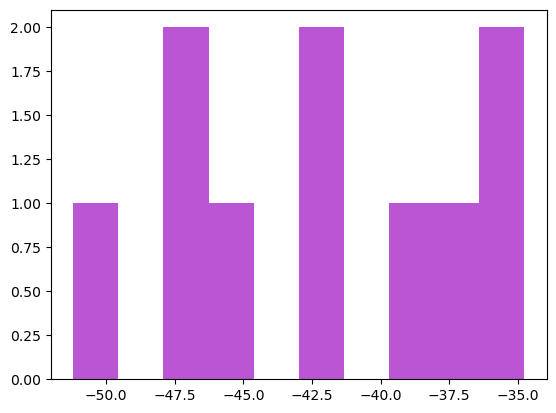

In [106]:
plt.figure()
plt.hist(current_likes)
plt.show()

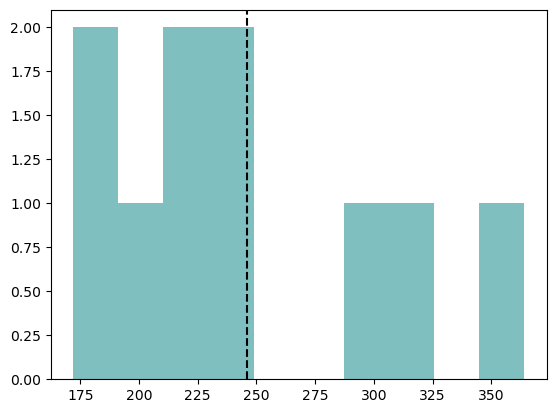

In [107]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

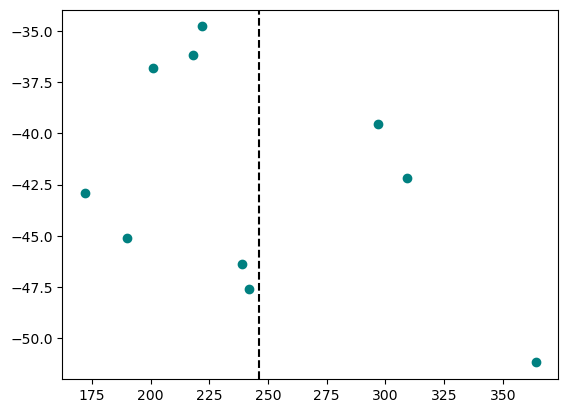

In [108]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

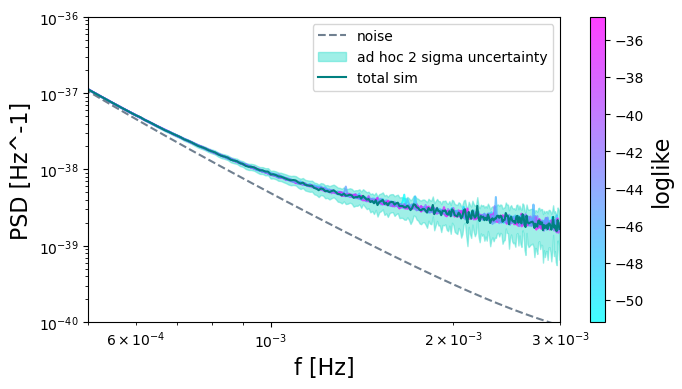

In [114]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.savefig('lowf_nbv14_spectra.png',dpi=200)
plt.show()

In [110]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [111]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

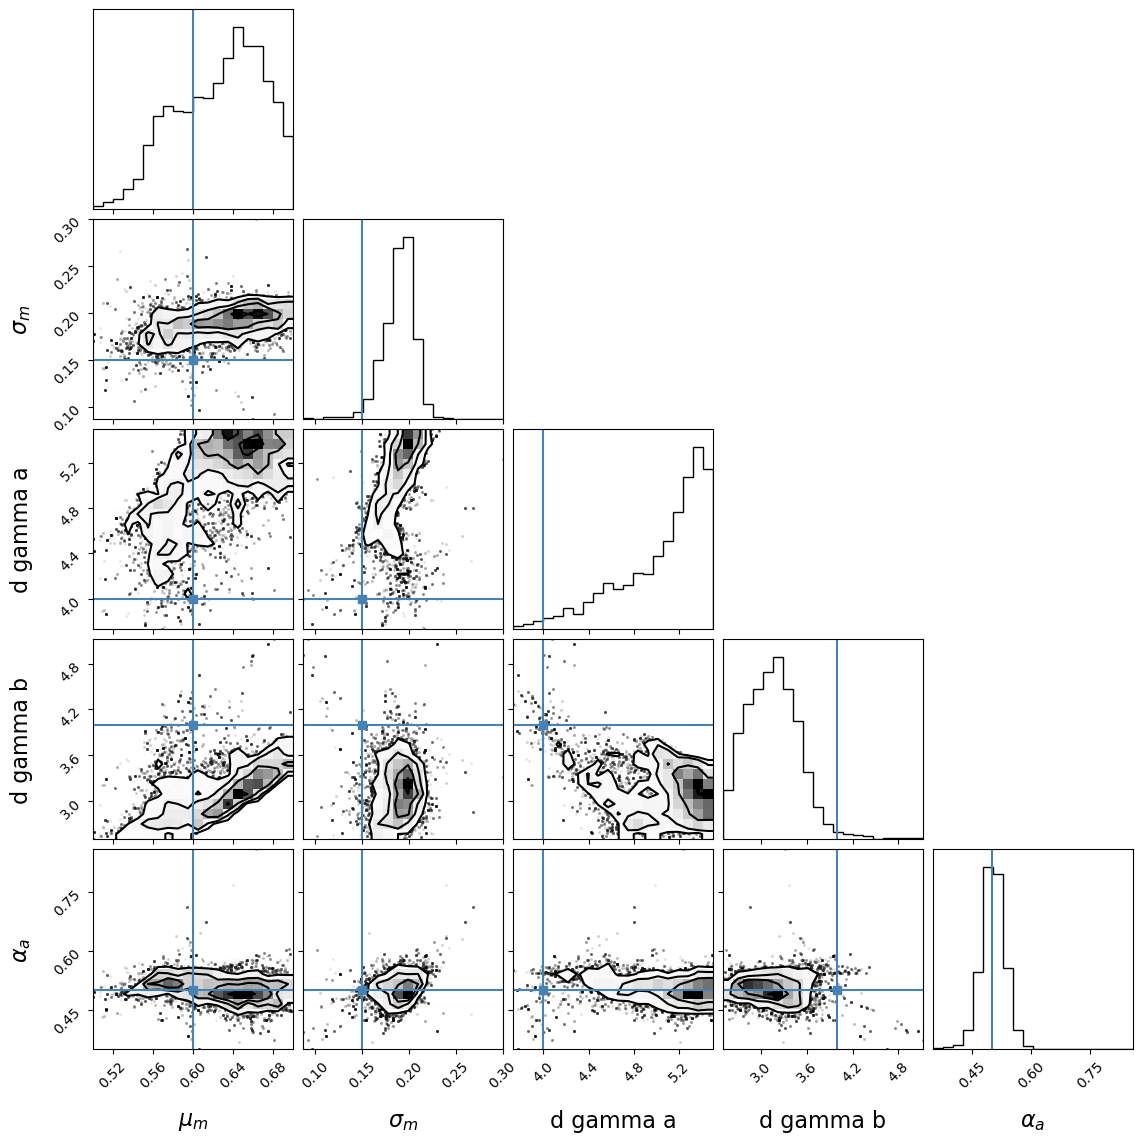

In [113]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[250:,]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
plt.savefig('lowf_nbv14_corners.png',dpi=200)
plt.show()

In [119]:
np.savez('lowf_nbv14_samples.npz',chain=ensemble.get_chain()['model_0'])

Excellent! Everything is running smoothly and the parameter space is being properly explored with clear convergence. Next steps: Do some optimization, clean things up a bit, and perform a test run on a larger frequency range!

In [127]:
def test_func(x,y,**plt_kwargs):
    plt.plot(x,y,**plt_kwargs)
    return
def plt_wrapper(**plt_kwargs):
    x, y = np.linspace(0,10,100),2*np.linspace(0,10,100)
    test_func(x,y,**plt_kwargs)
    return

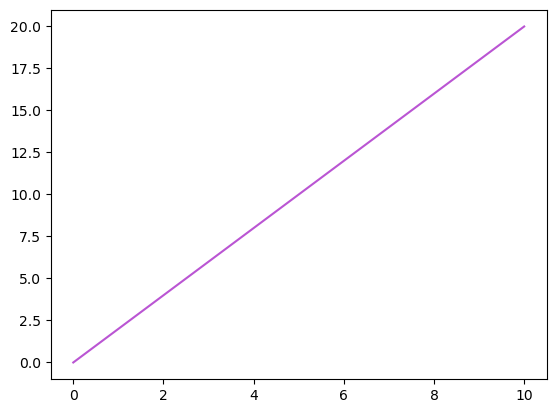

In [132]:
tt =  (np.linspace(0,10,100),2*np.linspace(0,10,100))
test_funct(*tt)

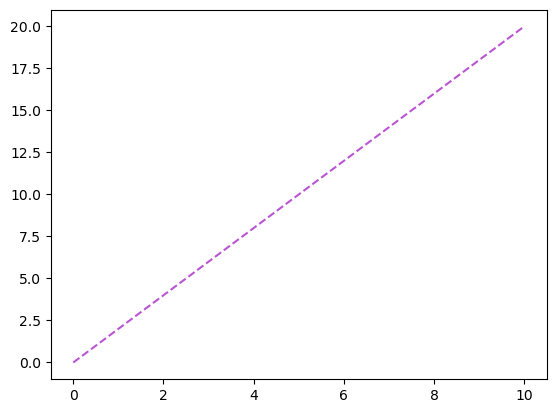

In [128]:
plt.figure()
plt_wrapper(ls='--')
plt.show()

In [130]:
dir(ensemble)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_previous_state',
 '_priors',
 '_random',
 'acceptance_fraction',
 'all_moves',
 'all_walkers',
 'backend',
 'blobs_dtype',
 'branch_names',
 'compute_log_like',
 'compute_log_prior',
 'fill_zero_leaves_val',
 'get_autocorr_time',
 'get_betas',
 'get_blobs',
 'get_chain',
 'get_inds',
 'get_last_sample',
 'get_log_like',
 'get_log_posterior',
 'get_log_prior',
 'get_model',
 'get_nleaves',
 'get_value',
 'has_reversible_jump',
 'info',
 'iteration',
 'log_like_fn',
 'move_keys',
 'moves',
 'nbranches',
 'ndims',
 'nleaves_max',
 'ntemps',
 'num_repeats_in_model',
 'num_repeats_rj',
 'nwalkers',
 'plot_it

In [131]:
ensemble.ndims,ensemble.nwalkers

({'model_0': 5}, 10)